In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDCNY'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
30,14/2/2000,8.2781,8.2785,8.2778,8.2779,0.0,-5000.000000,-6666.666667,-8333.333333,4059.405941,...,-0.003624,-0.008456,-0.012079,8.278471,-0.000317,-32.710280,8.27865,8.27830,8.278475,8.27815
31,15/2/2000,8.2779,8.2784,8.2775,8.2777,0.0,-4615.384615,-5882.352941,-7236.842105,3079.331942,...,-0.007248,-0.006040,-0.010871,8.278390,-0.000340,-58.139535,8.27845,8.27765,8.278050,8.27795
32,16/2/2000,8.2777,8.2777,8.2777,8.2777,0.0,-2105.263158,-2615.384615,-3201.970443,-2981.132075,...,-0.004832,-0.007248,-0.006040,8.278304,-0.000357,-75.568599,8.27805,8.27760,8.277825,8.27770
33,17/2/2000,8.2777,8.2777,8.2769,8.2772,0.0,-2142.857143,-2731.277533,-3036.437247,-5604.155276,...,-0.006040,-0.010872,-0.013288,8.278172,-0.000398,-122.604098,8.27770,8.27730,8.277500,8.27730
34,18/2/2000,8.2772,8.2772,8.2772,8.2779,1.0,-3000.000000,-2465.753425,-2796.610169,-4539.781591,...,0.006041,0.002416,-0.002416,8.278094,-0.000386,-84.355828,8.27745,8.27705,8.277250,8.27720


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
30,14/2/2000,8.2785,8.2781,8.2778,8.2779,-5000.000000,-6666.666667,-8333.333333,4059.405941,-4424.035056,...,-0.003624,-0.008456,-0.012079,8.278471,-0.000317,-32.710280,8.27865,8.27830,8.278475,8.27815
31,15/2/2000,8.2784,8.2779,8.2775,8.2777,-4615.384615,-5882.352941,-7236.842105,3079.331942,-4039.184112,...,-0.007248,-0.006040,-0.010871,8.278390,-0.000340,-58.139535,8.27845,8.27765,8.278050,8.27795
32,16/2/2000,8.2777,8.2777,8.2777,8.2777,-2105.263158,-2615.384615,-3201.970443,-2981.132075,-3985.585586,...,-0.004832,-0.007248,-0.006040,8.278304,-0.000357,-75.568599,8.27805,8.27760,8.277825,8.27770
33,17/2/2000,8.2777,8.2777,8.2769,8.2772,-2142.857143,-2731.277533,-3036.437247,-5604.155276,-3871.743487,...,-0.006040,-0.010872,-0.013288,8.278172,-0.000398,-122.604098,8.27770,8.27730,8.277500,8.27730
34,18/2/2000,8.2772,8.2772,8.2772,8.2779,-3000.000000,-2465.753425,-2796.610169,-4539.781591,-3894.318876,...,0.006041,0.002416,-0.002416,8.278094,-0.000386,-84.355828,8.27745,8.27705,8.277250,8.27720


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.99932796, 0.99919585, 0.99906283, ..., 0.99928557, 0.99936205,
        0.99921683],
       [0.99928315, 0.9991065 , 0.99892895, ..., 0.99899533, 0.99917179,
        0.99912732],
       [0.99896953, 0.99901716, 0.99901821, ..., 0.99897301, 0.99907106,
        0.99901544],
       ...,
       [0.40080645, 0.38786633, 0.38852196, ..., 0.38527829, 0.38965181,
        0.39415977],
       [0.40080645, 0.38786633, 0.38852196, ..., 0.38818066, 0.39394957,
        0.39415977],
       [0.43799283, 0.42195318, 0.4225723 , ..., 0.40521533, 0.41177853,
        0.42980533]])

In [10]:
input_data.shape

(4719, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.99932796, 0.99919585, 0.99906283, ..., 0.99928557, 0.99936205,
        0.99921683],
       [0.99928315, 0.9991065 , 0.99892895, ..., 0.99899533, 0.99917179,
        0.99912732],
       [0.99896953, 0.99901716, 0.99901821, ..., 0.99897301, 0.99907106,
        0.99901544],
       ...,
       [0.40080645, 0.38786633, 0.38852196, ..., 0.38527829, 0.38965181,
        0.39415977],
       [0.40080645, 0.38786633, 0.38852196, ..., 0.38818066, 0.39394957,
        0.39415977],
       [0.43799283, 0.42195318, 0.4225723 , ..., 0.40521533, 0.41177853,
        0.42980533]])

In [13]:
input_data[[0],1:]

array([[0.99919585, 0.99906283, 0.9991065 , 0.33333333, 0.33333333,
        0.33333333, 0.54059406, 0.47787982, 0.46971481, 0.99916148,
        0.04811164, 0.0517032 , 0.04990403, 0.05932647, 0.08213766,
        0.08213766, 0.04990403, 0.04990403, 0.05932647, 0.08213766,
        0.08213766, 0.41278138, 0.40485423, 0.41279028, 0.43351816,
        0.99945026, 0.44628682, 0.45238818, 0.99941666, 0.99928557,
        0.99936205, 0.99921683]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.99919585, 0.99906283, 0.9991065 , ..., 0.99928557,
          0.99936205, 0.99921683]],

        [[0.9991065 , 0.99892895, 0.99901716, ..., 0.99899533,
          0.99917179, 0.99912732]],

        [[0.99901716, 0.99901821, 0.99901716, ..., 0.99897301,
          0.99907106, 0.99901544]],

        ...,

        [[0.99973195, 0.99964298, 0.9996426 , ..., 0.99962046,
          0.99968662, 0.99970911]],

        [[0.9996426 , 0.99937522, 0.99937455, ..., 0.99950883,
          0.99967543, 0.99964198]],

        [[0.99937455, 0.99937522, 0.99941923, ..., 0.99937487,
          0.99960828, 0.99957485]]],


       [[[0.9991065 , 0.99892895, 0.99901716, ..., 0.99899533,
          0.99917179, 0.99912732]],

        [[0.99901716, 0.99901821, 0.99901716, ..., 0.99897301,
          0.99907106, 0.99901544]],

        [[0.99901716, 0.99866119, 0.99879378, ..., 0.99883905,
          0.99892556, 0.99883643]],

        ...,

        [[0.9996426 , 0.99937522, 0.99937455, ..., 0.99950883,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4203, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4203/4203 [==============================] - 8s 2ms/step - loss: 0.0091
Epoch 2/5
4203/4203 [==============================] - 6s 1ms/step - loss: 1.5882e-04
Epoch 3/5
4203/4203 [==============================] - 6s 2ms/step - loss: 1.207

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([6.284 , 6.299 , 6.3054, 6.2885, 6.2837, 6.2905, 6.3105, 6.3105,
       6.3176, 6.3075, 6.2888, 6.2943, 6.2934, 6.287 , 6.2863, 6.2903,
       6.2807, 6.2975, 6.3173, 6.3208, 6.3283, 6.3365, 6.348 , 6.348 ,
       6.365 , 6.37  , 6.366 , 6.368 , 6.3707, 6.3827, 6.3696, 6.3489,
       6.3411, 6.3795, 6.38  , 6.3715, 6.38  , 6.3934, 6.3784, 6.3914,
       6.3952, 6.3918, 6.4009, 6.4227, 6.4337, 6.419 , 6.4219, 6.4235,
       6.413 , 6.4061, 6.3962, 6.4122, 6.4089, 6.409 , 6.4116, 6.4055,
       6.4394, 6.4394, 6.4853, 6.4793, 6.5068, 6.5077, 6.545 , 6.5842,
       6.6152, 6.6317, 6.6427, 6.6719, 6.7183, 6.641 , 6.6454, 6.6658,
       6.6426, 6.6402, 6.6826, 6.705 , 6.7053, 6.7051, 6.7077, 6.7227,
       6.7841, 6.8117, 6.7986, 6.8262, 6.8055, 6.7955, 6.8401, 6.8397,
       6.8388, 6.8311, 6.8507, 6.8935, 6.855 , 6.8623, 6.8417, 6.8375,
       6.8603, 6.8913, 6.8946, 6.9348, 6.9235, 6.8939, 6.8673, 6.8506,
       6.8475, 6.8787, 6.8911, 6.8268, 6.8208, 6.8292, 6.8445, 6.848 ,
      

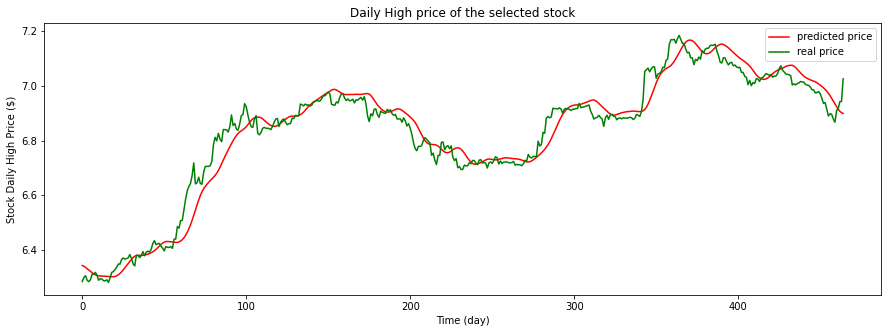

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,6.2840,6.342738,NaN,NaN
1,6.2990,6.340154,6.342738,-0.002584
2,6.3054,6.335985,6.340154,-0.004169
3,6.2885,6.331184,6.335985,-0.004801
4,6.2837,6.326290,6.331184,-0.004894
...,...,...,...,...
460,6.9089,6.923951,6.934033,-0.010082
461,6.9172,6.914397,6.923951,-0.009554
462,6.9426,6.906712,6.914397,-0.007685
463,6.9426,6.901538,6.906712,-0.005174


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,6.2840,6.342738,NaN,NaN,NaN,6.267675,NaN
1,6.2990,6.340154,6.342738,-0.002584,-0.082042,6.290775,0.003686
2,6.3054,6.335985,6.340154,-0.004169,-0.132236,6.290425,-0.000056
3,6.2885,6.331184,6.335985,-0.004801,-0.152703,6.272000,-0.002929
4,6.2837,6.326290,6.331184,-0.004894,-0.155768,6.279775,0.001240
5,6.2905,6.321211,6.326290,-0.005079,-0.161466,6.288525,0.001393
6,6.3105,6.316255,6.321211,-0.004957,-0.157100,6.294225,0.000906
7,6.3105,6.311894,6.316255,-0.004360,-0.138191,6.294225,0.000000
8,6.3176,6.308446,6.311894,-0.003448,-0.109163,6.306225,0.001907
9,6.3075,6.305945,6.308446,-0.002501,-0.079293,6.288350,-0.002835


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

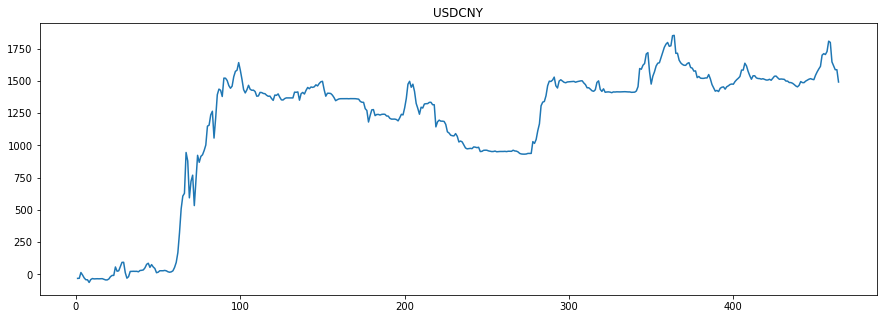

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.title(currency_name)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

1.0959907044587363

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.1220657276995305

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 709.2856818208887 , from day 99 , to day 273
